#### Imports

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean, cosine

import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, homogeneity_score, v_measure_score, completeness_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import chart_studio.plotly as py
import seaborn as sns
import shap

pd.set_option('display.max_colwidth', 1000)

C:\Users\s164255\anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning:

urllib3 (1.26.3) or chardet (4.0.0) doesn't match a supported version!



#### View dataset

In [2]:
df = pd.read_csv('../datasets/davidson_dataset.csv')
print(df.shape)
df.head(10)

(5233, 4)


,index,label,text,processed
0,1,0,as a woman you should not complain about cleaning up your house as a man you should always take the garbage out,as a woman you should not complain about cleaning up your house as a man you should always take the garbage out
1,2,0,momma said no cats inside my doghouse,momma said no cats inside my doghouse
2,3,0,simply addicted to guys hot scally lad,simply addicted to guys hot scally lad
3,4,0,and hot soles,and hot soles
4,5,0,lemmie eat a oreo do these dishes one oreo,lemmie eat a oreo do these dishes one oreo
5,6,0,why the eggplant emoji would he say she looked like scream,why the eggplant emoji would he say she looked like scream
6,7,0,baby monkey bathtime this is so adorable,baby monkey bathtime this is so adorable
7,8,0,baseball season for the win yankees this is where the love started,baseball season for the win yankees this is where the love started
8,9,0,i am an early bird and i am a night owl so i am wise and have worms,i am an early bird and i am a night owl so i am wise and have worms
9,10,0,overdosing on heavy drugs does not sound bad tonight i do that every day,overdosing on heavy drugs does not sound bad tonight i do that every day


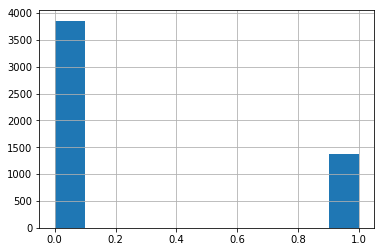

In [3]:
df["label"].hist()

In [4]:
x = df['text'].values
y = df['label'].values

#### Word representation
We are going to use TF*IDF (Term frequency- Inverse document frequency) vectorizer to convert our text into numbers.

TF = Frequency of term

IDF = No of docs/ No of docs with the term

In [5]:
tfid = TfidfVectorizer(max_features=5000)
x = tfid.fit_transform(x).toarray()
x.shape

(5233, 5000)

In [8]:
tfid.get_feature_names()

['ability',
 'able',
 'abortion',
 'about',
 'above',
 'absolute',
 'absolutely',
 'absurd',
 'abu',
 'abuse',
 'accent',
 'accept',
 'acceptable',
 'accident',
 'accidentally',
 'according',
 'account',
 'accounts',
 'accurate',
 'ace',
 'acquire',
 'across',
 'act',
 'acting',
 'action',
 'active',
 'activities',
 'activity',
 'actor',
 'actual',
 'actually',
 'adam',
 'add',
 'added',
 'address',
 'admit',
 'admits',
 'adopting',
 'adorable',
 'adult',
 'advanced',
 'advice',
 'afc',
 'afford',
 'afghanistan',
 'afraid',
 'africa',
 'african',
 'after',
 'again',
 'against',
 'age',
 'agenda',
 'ago',
 'agree',
 'agreed',
 'aid',
 'aids',
 'aim',
 'air',
 'airlines',
 'airs',
 'aka',
 'al',
 'alabama',
 'alarm',
 'albino',
 'album',
 'alcohol',
 'alcoholism',
 'alex',
 'alfredo',
 'alien',
 'aliens',
 'alike',
 'alive',
 'all',
 'allah',
 'allied',
 'allowed',
 'almost',
 'alone',
 'along',
 'alot',
 'already',
 'alright',
 'also',
 'aluminum',
 'alves',
 'always',
 'am',
 'amazing'

#### Splitting data
  We split data into training, test and pool. Pool is the unlabelled pool we want to generate SHAP clusters for.

In [ ]:
np.random.seed(100)
indices =  np.random.randint(low=0, high=x.shape[0], size=x.shape[0])
train_indices = indices[0:round(0.7*x.shape[0])]
test_indices = indices[round(0.7*x.shape[0]): round(0.8*x.shape[0])]
pool_indices = indices[round(0.8*x.shape[0]):]
df_train = df.iloc[train_indices]['text'].values
df_test = df.iloc[test_indices]['text'].values
df_pool = df.iloc[pool_indices]['text'].values
x_train = x[train_indices]
y_train = y[train_indices]
x_test = x[test_indices]
y_test = y[test_indices]
x_pool = x[pool_indices]
y_pool = y[pool_indices]

#### Model fitting
We do a simple grid search to find the best SVM model.

In [ ]:

max_iter=1000
C= [0.5, 1, 2]
best_f1 = 0
model = None
for c in C:
    m = SVC( max_iter=max_iter, C=c, kernel='linear', class_weight='balanced', probability=True)
    m.fit(x_train, y_train)
    m.score(x_train,y_train)
    predictions = m.predict(x_test)
    f1 = f1_score(predictions, y_test)
    if  f1 > best_f1:
        model = m
        best_f1 = f1


We measure the f1_score and plot confusion matrix. Recall:
- f1 score = 2PR/ (P+R)
- Precision = actual positives/ predicted positives
- Recall = predicted positives/ total actual positives

In [ ]:
predictions = model.predict(x_pool)
f1_score(predictions, y_pool), accuracy_score(y_pool, predictions)


Convert predict probability to uncertainty. In binary classification this would be the same as 1-P

In [ ]:
classwise_uncertainty = model.predict_proba(x_pool)
uncertainty = 1 - np.max(classwise_uncertainty, axis=1)

In [ ]:
plt.hist(uncertainty)
plt.show()

In [ ]:
sns.heatmap(confusion_matrix(y_pool, predictions),annot=True)

#### Explain model using SHAP

Refer https://christophm.github.io/interpretable-ml-book/shap.html

The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. The SHAP explanation method computes Shapley values from coalitional game theory. The feature values of a data instance act as players in a coalition. Shapley values tell us how to fairly distribute the “payout” (= the prediction) among the features

We call the SHAP explainer for linear models
shapely values produced have same dimensions as data passed

In [ ]:
explainer = shap.LinearExplainer(model, x_train,feature_dependence="independent")
shap_values_train = explainer.shap_values(x_train)
shap_values_pool = explainer.shap_values(x_pool)

In [ ]:
shap_values_pool.shape

Explain a single positive prediction at 'index'

In [ ]:
postive_index = 0
index = np.where(predictions==1)[0][postive_index]
print("text ", df_test[index], " prediction: ", predictions[index], "actual ", y_test[index])
shap.force_plot(explainer.expected_value, 
                               shap_values_pool[index,:], 
                               x_test[index,:], feature_names = tfid.get_feature_names(),
               matplotlib=True)

Explain the overall feature importance using summary

In [ ]:
shap.summary_plot(shap_values_pool, x_pool, feature_names=tfid.get_feature_names())

In [ ]:
shap_values_pool.shape

#### Clustering data
We are going to cluster the training data using SHAP explanations (shapely space)
SHAP clustering works by clustering on Shapley values of each instance. 
This means that you cluster instances by explanation similarity.

In [ ]:
n_clusters = 50
kmeans = KMeans(n_clusters= n_clusters, n_jobs=-1, max_iter=600)
kmeans.fit(shap_values_pool)

In [ ]:
homogeneity_score( y_pool, kmeans.labels_), v_measure_score(y_pool, kmeans.labels_)

We use cosine distance instead of euclidean distance to measure the similarity between the documents.
As the size of the document increases, the number of common words (euclidean) tend to increase 
even if the documents talk about different topics. The cosine similarity helps overcome this fundamental flaw 
and finds the similarity irrespective of size.

https://www.machinelearningplus.com/nlp/cosine-similarity/

In [ ]:
# Find similarity of each point in cluster to its centroid
similarity_to_center = []
for i, instance in enumerate(shap_values_pool):
    cluster_label = kmeans.labels_[i] # cluster of this instance
    centroid = kmeans.cluster_centers_[cluster_label] # cluster center of the cluster of that instance
    similarity = 1-cosine(instance, centroid) # 1- cosine distance gives similarity
    similarity_to_center.append(similarity)
    
centroid_match = [None]*n_clusters
centroid_indices =[None]*n_clusters
for i, instance in enumerate(shap_values_pool):
    cluster_label = kmeans.labels_[i]     
    if centroid_match[cluster_label] is None or similarity_to_center[i] > centroid_match[cluster_label]:
        centroid_indices[cluster_label] = i
        centroid_match[cluster_label] = similarity_to_center[i]

#### Visualize clusters

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=20)
principals = tsne.fit_transform(shap_values_pool)

In [ ]:
data = []
colorscale = [[0, 'mediumturquoise'], [1, 'salmon']]
collect = dict()
sizes = []
color = ['hsl(' + str(h) + ',80%' + ',50%)' for h in np.linspace(0, 255, n_clusters)]
df_final_labels = pd.DataFrame()
for cluster_id in np.unique(kmeans.labels_):
    cluster_indices = np.where(kmeans.labels_ == cluster_id)    
    
    cluster_text = df_pool[cluster_indices]
    center_index = centroid_indices[cluster_id]
    center_text = df_pool[center_index]
    sizes.append(len(cluster_indices[0]))
    df_cluster = pd.DataFrame({'text': cluster_text})
    df_cluster['cluster_id'] = cluster_id
    df_cluster['centroid'] = False
    df_cluster = df_cluster.append({'text':center_text, 'cluster_id':cluster_id,
                                    'centroid':True }, ignore_index=True)
    df_final_labels = pd.concat([df_final_labels, df_cluster])

    cp = principals[cluster_indices]
    data.append(go.Heatmap(x=cp[:, 0],
                           y=cp[:, 1],
                           z=uncertainty[cluster_indices],
                           name='uncertainity map',
                           visible=True,
                           showscale=False,
                           colorscale=colorscale,
                                         ))
    data.append(go.Scatter(x = cp[:,0],
                   y = cp[:,1],
                   mode='markers',                    
                hovertext=cluster_text,
                            marker=dict(color=color[cluster_id],
                                                   size=10),
                           name = 'cluster '+ str(cluster_id)
                          ))
    data.append(go.Scatter(x = [principals[center_index, 0]],
                   y = [principals[center_index, 1]],
                   mode='markers',  
                           marker=dict(color=color[cluster_id],
                                                   size=15,
                                                   line=dict(color='black', width=5)),
                           name = 'centroid cluster '+ str(cluster_id),
                           visible='legendonly',
                           
                          ))
    collect[cluster_id] = df_pool[cluster_indices]
    
fig = go.Figure(data=data)
fig.show()
df_final_labels.to_csv('df_input.csv')

In [ ]:
sizes

#### Analyze uncertainty within clusters

In [ ]:
data = []
ranges = []
for cluster_id in np.unique(kmeans.labels_):
    cluster_indices = np.where(kmeans.labels_ == cluster_id)    
    uncertainty_cluster = uncertainty[cluster_indices]
    rng = np.max(uncertainty_cluster)- np.min(uncertainty_cluster)
    print(cluster_id, "range ", rng)
    ranges.append(rng)
    print(y_pool[cluster_indices])
    print("\n")
    data.append(go.Histogram(x=uncertainty_cluster, name=str(cluster_id), showlegend=True,visible='legendonly'))
fig = go.Figure(data=data)
url=py.plot(fig, filename='clusters_50', sharing='public')

In [ ]:
max_uncertain_indices = (-uncertainty).argsort()[:20]
y_pool[max_uncertain_indices], uncertainty[max_uncertain_indices]

In [ ]:
cluster_id = 8
cluster_indices = np.where(kmeans.labels_ == cluster_id)    
d = {'text' : df_pool[cluster_indices], 'uncertainty': uncertainty[cluster_indices], 'label': y_pool[cluster_indices]}

pd.DataFrame(d)


In [ ]:
i=cluster_indices[0][10]
shap.force_plot(explainer.expected_value, shap_values_pool[i,:], x_pool[i,:], feature_names = tfid.get_feature_names(),
               matplotlib=True)

In [ ]:
cluster_indices

#### Find optimal cluster size

In [ ]:
homogeneity_scores = []
v_measure_scores = []
completeness_scores = []
n_iters = 10
ranges = list(range(10, 110, 10))
for k in ranges:
    vavg = 0
    havg = 0
    cavg = 0
    for i in range(n_iters):
        kmeans = KMeans(n_clusters= n_clusters, n_jobs=-1)
        kmeans.fit(shap_values_pool)
        v = v_measure_score(labels_pred=kmeans.labels_, labels_true=y_pool) 
        h = homogeneity_score(labels_pred=kmeans.labels_, labels_true=y_pool) 
        c = completeness_score(labels_pred=kmeans.labels_, labels_true=y_pool) 
        vavg += v
        havg += h
        cavg += c
    homogeneity_scores.append(havg/n_iters)
    v_measure_scores.append(vavg/n_iters)
    completeness_scores.append(cavg/n_iters)
    print(k, "done")



In [ ]:
data = [go.Scatter(x=ranges, y=homogeneity_scores, mode="lines", name="homogeneity"),
        go.Scatter(x=ranges, y=v_measure_scores, mode="lines", name="v_measure"),
        go.Scatter(x=ranges, y=completeness_scores, mode="lines", name="completeness")
        ]
fig = go.Figure(data=data)
fig.update_layout(xaxis_title="no of clusters")
fig.show()

#### Add centroid of each cluster to the training set and retrain the model

In [ ]:
train_indices_new = np.append(train_indices, centroid_indices)


In [ ]:
model1 = SVC( max_iter=max_iter, C=C, kernel='linear')
x_train_new = x[train_indices_new]
y_train_new = y[train_indices_new]
model1.fit(x_train_new, y_train_new)

In [ ]:
model1.score(x_train_new, y_train_new), model1.score(x_test, y_test)

In [ ]:
predictions1 = model1.predict(x_test)
f1_score(y_test, predictions1)

In [ ]:
accuracy_score(y_test, predictions1)

#### Add entire x_pool back to training instead of just centroids

In [ ]:
train_indices_full = np.append(train_indices, pool_indices)

In [ ]:
model2 = SVC(max_iter=max_iter, C=C, kernel='linear')
x_train_full = x[train_indices_full]
y_train_full = y[train_indices_full]
model2.fit(x_train_full, y_train_full)
model2.score(x_train_full, y_train_full), model2.score(x_test, y_test)

In [ ]:
predictions2 = model2.predict(x_test)
f1_score(y_test, predictions2)

In [ ]:
accuracy_score(y_test, predictions2)

#### Compare

In [ ]:
print("Model with 20% train ", f1_score(y_test, predictions))
print("Model with 20% train + center ", f1_score(y_test, predictions1))
print("Model with 20% train + 60% pool ", f1_score(y_test, predictions2))

In [ ]:
print("Model with 20% train ", accuracy_score(y_test, predictions))
print("Model with 20% train + center ", accuracy_score(y_test, predictions1))
print("Model with 20% train + 60% pool ", accuracy_score(y_test, predictions2))